In this code, I want to compare slope constrained and linear spline model. for the former, i will set the same grid which i will use for the latter. thus both the models would be equivalent and ideally should behave the same!

In [288]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained
from activations.linearspline import LinearSpline

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons


import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [289]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


mean = 0
std_dev = 1
total_samples = 10000#50000

train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 3#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 7000
Validation set size: 1500
Test set size: 1500


In [290]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    loss_2 = torch.sum(torch.log(torch.abs(det_jacobian) + 1e-10))
    dataset_length = z.size(0)
    loss = (loss_1-loss_2)/ dataset_length
    return loss

In [291]:
model1 = LinearSpline(mode='fc',
                        num_activations=1,
                        size=7,# number of knots is size -2
                        range_=10,
                        init="absolute_value",#"maxmin",# what if I try relu activation function?
                        lipschitz_constrained=1)


In [437]:
SIZE=5;RANGE=5
model2 = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=SIZE,# number of knots is size -2
                        range_=RANGE,
                        # grid_values=torch.sort(torch.rand(SIZE) * (RANGE - 0) + 0)[0],
                        init="maxmin",#"maxmin",# what if I try relu activation function?
                        smin=0.01,
                        smax=2,
                        slope_constrained=1
) # slopes of splines is 1, obviously


initial nodal_val_locs: tensor([[-2.9132, -1.4608,  1.6172,  2.1882,  2.9779]])
initial fn values: Parameter containing:
tensor([2.9132, 1.4608, 1.6172, 2.1882, 2.9779], requires_grad=True)


In [438]:
model2.slope_constrained_coefficients_vect

tensor([1.7397, 1.7542, 1.9105, 2.4816, 3.2712], grad_fn=<ViewBackward0>)

In [421]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(5, 5))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.7, 
                density=True, label=labels_list[i])
        plt.legend()

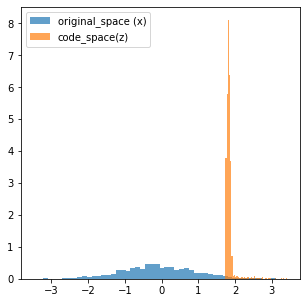

In [439]:
input_tensor = torch.tensor(test_data)
# output_tensor1=model1(input_tensor)
output_tensor2=model2(input_tensor)
# plot_multiple_histogram([input_tensor.numpy(), output_tensor1.detach().numpy()
#                         ],
                        # labels_list=["original_space (x)","code_space(z)"])
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["original_space (x)","code_space(z)"])

In [296]:

def plot_with_annotations(x, y,label="with const coeffs",
                title="Plot with (x, y) Annotations", 
            xlabel="X-axis", ylabel="Y-axis",
            txt_color="red"):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, "-o",label=label)  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    for x_val, y_val in zip(x, y):
        plt.annotate(
            f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
            (x_val, y_val),  # The point to annotate
            textcoords="offset points",  # Offset the text slightly
            xytext=(5, 5),  # Offset (5, 5) pixels
            fontsize=8,  # Font size of the annotation
            color=txt_color # Optional: text color
        )
        plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)  # Optional: Add a grid

In [297]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [298]:
# train and evaluate fn.
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1
    , track_coefficients = False, type_model="ls"#"scls"
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0
        total_train_and_regul_loss=0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            if type_model=="ls":  #activations.linearspline_slope_constraint.LinearSplineSlopeConstrained
                slope_const_coeffs = model.lipschitz_coefficients_vect.detach().numpy()
            elif type_model== "scls":
                slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss = nll_loss(encoded, model.grad_x_temp)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)
            # print(f"tv2 regul: {tv2_regul}")
            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss
            # print(f"lambda_tv2 {(lambda_tv2 )} x tv2_regul: {lambda_tv2 * tv2_regul}")
            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_and_regul_loss += total_loss.item()
            total_train_loss += train_loss.item()
        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # i commented it because i also want to see how coefficients look before the training begins
        # if track_coefficients:
        #     # do I really need to change them to numpy?
        #     coeffs=model.coefficients_vect.detach().numpy()
        #     slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
        #     coeffs_evol.append(list(coeffs))
        #     slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)
        avg_train_and_regul_loss = total_train_and_regul_loss / len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded = model(val_inputs)

                    # Loss calculation for validation
                    val_loss = nll_loss(val_encoded, model.grad_x_temp)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f" train NLL+{lambda_tv2}XTV2: {avg_train_and_regul_loss}, "
                    f"Training NLL Loss: {average_train_loss}, "
                    f"Validation NLL Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses


In [240]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [63]:
train_loss, val_loss, coeffs_unconstrained_evol, coeffs_const_evol = train_and_evaluate(
    model = model1,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=30, 
    scheduler_type="ReduceLROnPlateau",
    lr=5e-5, #
    print_after=1,
    track_coefficients=1,
    type_model="ls"
) 

Training Progress:   3%|▎         | 1/30 [00:15<07:19, 15.16s/it]

Epoch 1/30, Training Loss: 7.224953658783037, Validation Loss: 6.678363315105438, LR: 5e-05


Training Progress:   7%|▋         | 2/30 [00:27<06:25, 13.77s/it]

Epoch 2/30, Training Loss: 6.259398399404511, Validation Loss: 5.8691216592788695, LR: 5e-05


Training Progress:  10%|█         | 3/30 [00:40<05:59, 13.30s/it]

Epoch 3/30, Training Loss: 5.5582710119425585, Validation Loss: 5.258415822982788, LR: 5e-05


Training Progress:  13%|█▎        | 4/30 [00:53<05:41, 13.13s/it]

Epoch 4/30, Training Loss: 5.020372859871888, Validation Loss: 4.7818894252777095, LR: 5e-05


Training Progress:  17%|█▋        | 5/30 [01:06<05:25, 13.03s/it]

Epoch 5/30, Training Loss: 4.597643904024041, Validation Loss: 4.40521928191185, LR: 5e-05


Training Progress:  20%|██        | 6/30 [01:19<05:12, 13.01s/it]

Epoch 6/30, Training Loss: 4.261407730307656, Validation Loss: 4.103814872026444, LR: 5e-05


Training Progress:  23%|██▎       | 7/30 [01:32<05:01, 13.13s/it]

Epoch 7/30, Training Loss: 3.9900228931746526, Validation Loss: 3.859861606955528, LR: 5e-05


Training Progress:  27%|██▋       | 8/30 [01:45<04:46, 13.04s/it]

Epoch 8/30, Training Loss: 3.769884162564102, Validation Loss: 3.661368787765503, LR: 5e-05


Training Progress:  30%|███       | 9/30 [01:58<04:33, 13.01s/it]

Epoch 9/30, Training Loss: 3.591349385136095, Validation Loss: 3.4980746412277224, LR: 5e-05


Training Progress:  33%|███▎      | 10/30 [02:11<04:19, 13.00s/it]

Epoch 10/30, Training Loss: 3.442483550682983, Validation Loss: 3.3631454515457153, LR: 5e-05


Training Progress:  37%|███▋      | 11/30 [02:24<04:05, 12.93s/it]

Epoch 11/30, Training Loss: 3.3186843361395897, Validation Loss: 3.2504217587709427, LR: 5e-05


Training Progress:  40%|████      | 12/30 [02:36<03:50, 12.82s/it]

Epoch 12/30, Training Loss: 3.2172138380794926, Validation Loss: 3.1561315954923628, LR: 5e-05


Training Progress:  43%|████▎     | 13/30 [02:49<03:38, 12.83s/it]

Epoch 13/30, Training Loss: 3.1323432191095497, Validation Loss: 3.076735405445099, LR: 5e-05


Training Progress:  47%|████▋     | 14/30 [03:02<03:24, 12.80s/it]

Epoch 14/30, Training Loss: 3.0601471727769805, Validation Loss: 3.010960581243038, LR: 5e-05


Training Progress:  50%|█████     | 15/30 [03:15<03:11, 12.76s/it]

Epoch 15/30, Training Loss: 2.99939489620638, Validation Loss: 2.9536885030865667, LR: 5e-05


Training Progress:  53%|█████▎    | 16/30 [03:27<02:58, 12.75s/it]

Epoch 16/30, Training Loss: 2.9468156617093313, Validation Loss: 2.905493102312088, LR: 5e-05


Training Progress:  57%|█████▋    | 17/30 [03:40<02:45, 12.69s/it]

Epoch 17/30, Training Loss: 2.90445819976576, Validation Loss: 2.8646429789066317, LR: 5e-05


Training Progress:  60%|██████    | 18/30 [03:53<02:32, 12.68s/it]

Epoch 18/30, Training Loss: 2.8671737140700566, Validation Loss: 2.831881309002638, LR: 5e-05


Training Progress:  63%|██████▎   | 19/30 [04:06<02:21, 12.84s/it]

Epoch 19/30, Training Loss: 2.834517000624535, Validation Loss: 2.802429655700922, LR: 5e-05


Training Progress:  67%|██████▋   | 20/30 [04:18<02:07, 12.80s/it]

Epoch 20/30, Training Loss: 2.8084713294080617, Validation Loss: 2.7785961605906486, LR: 5e-05


Training Progress:  70%|███████   | 21/30 [04:31<01:53, 12.62s/it]

Epoch 21/30, Training Loss: 2.787678879683306, Validation Loss: 2.759070746064186, LR: 5e-05


Training Progress:  73%|███████▎  | 22/30 [04:43<01:39, 12.47s/it]

Epoch 22/30, Training Loss: 2.7681567760403074, Validation Loss: 2.7424056001901627, LR: 5e-05


Training Progress:  77%|███████▋  | 23/30 [04:56<01:29, 12.76s/it]

Epoch 23/30, Training Loss: 2.754600020765543, Validation Loss: 2.73124326890707, LR: 5e-05


Training Progress:  80%|████████  | 24/30 [05:09<01:15, 12.67s/it]

Epoch 24/30, Training Loss: 2.741719418761561, Validation Loss: 2.7200091822743415, LR: 5e-05


Training Progress:  83%|████████▎ | 25/30 [05:21<01:03, 12.62s/it]

Epoch 25/30, Training Loss: 2.732764608921817, Validation Loss: 2.7137695412039755, LR: 5e-05


Training Progress:  87%|████████▋ | 26/30 [05:34<00:50, 12.59s/it]

Epoch 26/30, Training Loss: 2.7265547303787745, Validation Loss: 2.7082503801584243, LR: 5e-05


Training Progress:  90%|█████████ | 27/30 [05:47<00:37, 12.66s/it]

Epoch 27/30, Training Loss: 2.7238374476439953, Validation Loss: 2.7050563344359397, LR: 5e-05


Training Progress:  93%|█████████▎| 28/30 [05:59<00:25, 12.64s/it]

Epoch 28/30, Training Loss: 2.7217719899275004, Validation Loss: 2.704099708914757, LR: 5e-05


Training Progress:  97%|█████████▋| 29/30 [06:12<00:12, 12.71s/it]

Epoch 29/30, Training Loss: 2.7223008041618826, Validation Loss: 2.705492324113846, LR: 5e-05


Training Progress: 100%|██████████| 30/30 [06:24<00:00, 12.81s/it]

Epoch 30/30, Training Loss: 2.7242014242500554, Validation Loss: 2.7091495324969292, LR: 5e-05
Training complete


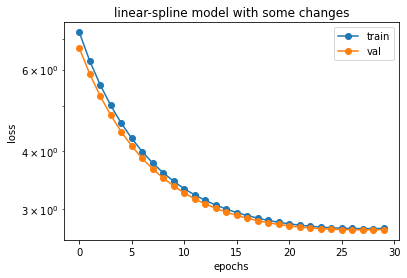

In [64]:
plot_loss_curves(train_loss=train_loss, val_loss=val_loss,
                title="linear-spline model with some changes", log_scale=1)

In [336]:
import math
def plot_coefficients_evolution(num_coeffs, coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs = List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    '''
    # Calculate grid dimensions dynamically
    cols = math.ceil(math.sqrt(num_coeffs))  # Number of columns
    rows = math.ceil(num_coeffs / cols)      # Number of rows
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axs = axs.flatten()  # Flatten for easier indexing

    for i in range(num_coeffs):
        ax = axs[i]
        ax.plot(coeffs[:, i], "-o", label=f"coeff[{i}]")
        ax.plot(slope_constr_coeffs[:, i], ":o", label=f"slope constr coeff[{i}]")
        ax.set_title(f"Coefficient {i}")
        ax.set_ylabel("Value")
        if log_scale:
            ax.set_yscale("log")
        ax.legend(loc='upper right')
        ax.grid(True)
    
    # Hide unused subplots
    for i in range(num_coeffs, len(axs)):
        axs[i].axis('off')
    
    # Set x-label for bottom row only
    for i in range(len(axs) - cols, len(axs)):
        axs[i].set_xlabel("Training epochs")
    
    fig.suptitle("Evolution of coefficients with training of a spline", y=1.00)
    plt.tight_layout()
    plt.show()

    


In [ ]:

def plot_multiple_z_with_normal_1d(models_params, test_data, model, 
                                   num_samples=1000, mean=0, 
                                   std=1, figsize=(12, 6)):
    """
    Plots multiple 1D scatter plots of z and 1D normal distribution samples in a grid.

    Args:
    - models_params (list): List of model parameters for each epoch.
    - test_data (numpy.ndarray): Test data for encoding.
    - model (torch.nn.Module): The neural network model.
    - num_samples (int): Number of points to sample from the 1D normal distribution.
    - mean (float): Mean of the 1D normal distribution.
    - std (float): Standard deviation of the 1D normal distribution.
    - figsize (tuple): Size of the overall figure.

    Returns:
    None
    """
    num_epochs = len(models_params)
    num_rows = int(np.ceil(np.sqrt(num_epochs)))
    num_cols = int(np.ceil(num_epochs / num_rows))
    
    # Prepare the normal distribution samples
    normal_samples = np.random.normal(mean, std, num_samples)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to easily iterate over
    
    test_tensor = torch.tensor(test_data, dtype=torch.float)

    for i, ax in enumerate(axes):
        if i < num_epochs:
            # Load model weights for the current epoch
            print(f"Model params for epoch {i}: {models_params[i]}")
            load_weights_into_model(model, models_params[i])
            
            # Encode the test data
            with torch.no_grad():
                encoded_test1, _ = model(test_tensor)
            
            # Plot on the subplot
            ax.scatter(normal_samples, np.zeros_like(normal_samples), color='blue', alpha=0.3, label="Normal Samples")
            ax.scatter(encoded_test1.squeeze().numpy(), np.zeros_like(encoded_test1), color='red', alpha=0.3, label="Encoded z")
            ax.set_title(f"Epoch {i}")
            ax.set_xlabel("Values")
            ax.set_yticks([])  # Remove y-axis ticks for clarity
            ax.grid(True)
        else:
            # Hide unused subplots
            ax.axis("off")
    
    # Add a common legend outside the grid
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.3, label="Normal Samples"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.6, label="Encoded z")
    ]
    fig.legend(handles=handles, loc="upper center", bbox_to_anchor=(0.5, 0.95), ncol=2, fontsize=10)
    
    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the legend at the top
    plt.show()


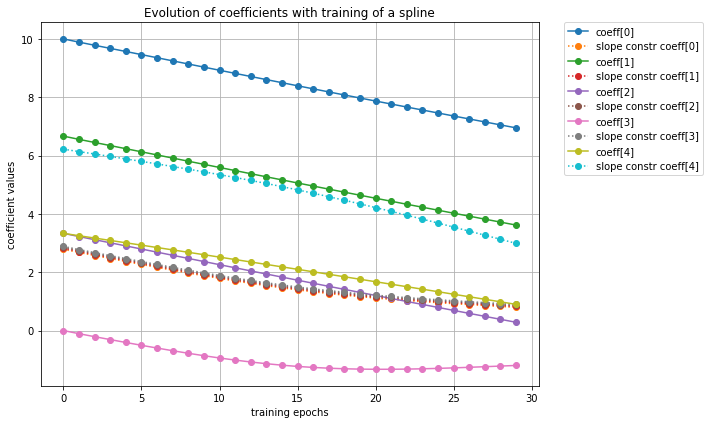

In [66]:
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol), 
                        np.array(coeffs_const_evol), log_scale=0)

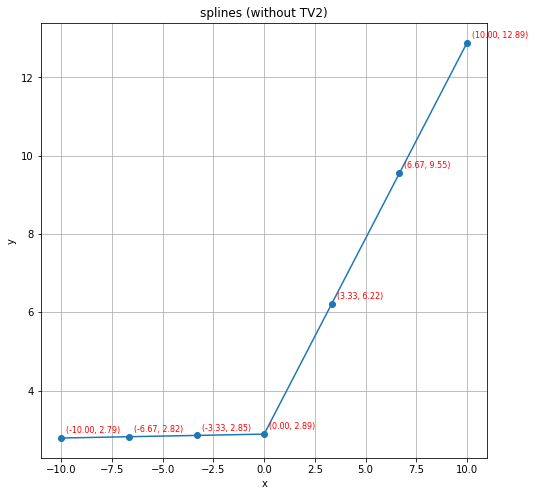

In [105]:
x1,y1= model1.grid_tensor.detach().numpy(),model1.lipschitz_coefficients_vect.detach().numpy()
# Add labels, title, and grid
plt.figure(figsize=(8,8))
plot_with_annotations(x1[0], y1,
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.show()

In [441]:
train_loss2, val_loss2, coeffs_unconstrained_evol2, coeffs_const_evol2 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=15, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0001, #
    print_after=1,
    track_coefficients=1,
    type_model="scls",
    tv2_regulation=True,
    lambda_tv2=2
) 

Training Progress:   7%|▋         | 1/15 [00:23<05:33, 23.81s/it]

Epoch 1/15,  train NLL+2XTV2: 3.306097651917197, Training NLL Loss: 2.7305211304801085, Validation NLL Loss: 2.706072909593582, LR: 0.0001


Training Progress:  13%|█▎        | 2/15 [00:47<05:06, 23.56s/it]

Epoch 2/15,  train NLL+2XTV2: 3.2258932636452213, Training NLL Loss: 2.658121267392682, Validation NLL Loss: 2.6095055236816407, LR: 0.0001


Training Progress:  20%|██        | 3/15 [01:10<04:41, 23.45s/it]

Epoch 3/15,  train NLL+2XTV2: 2.7337153895144395, Training NLL Loss: 2.594967114741514, Validation NLL Loss: 2.5839204416275026, LR: 0.0001


Training Progress:  27%|██▋       | 4/15 [01:33<04:15, 23.22s/it]

Epoch 4/15,  train NLL+2XTV2: 2.5621845797789637, Training NLL Loss: 2.5619440701851603, Validation NLL Loss: 2.507488093137741, LR: 0.0001


Training Progress:  33%|███▎      | 5/15 [01:56<03:52, 23.24s/it]

Epoch 5/15,  train NLL+2XTV2: 2.4895124882842703, Training NLL Loss: 2.489274162355405, Validation NLL Loss: 2.4372433269023897, LR: 0.0001


Training Progress:  40%|████      | 6/15 [02:19<03:27, 23.07s/it]

Epoch 6/15,  train NLL+2XTV2: 2.421081485304959, Training NLL Loss: 2.4208486600624974, Validation NLL Loss: 2.369955213308334, LR: 0.0001


Training Progress:  47%|████▋     | 7/15 [02:42<03:03, 22.98s/it]

Epoch 7/15,  train NLL+2XTV2: 2.35545464453783, Training NLL Loss: 2.355214799890788, Validation NLL Loss: 2.3056001336574554, LR: 0.0001


Training Progress:  53%|█████▎    | 8/15 [03:05<02:41, 23.01s/it]

Epoch 8/15,  train NLL+2XTV2: 2.292672415267941, Training NLL Loss: 2.2924246429477684, Validation NLL Loss: 2.243684055328369, LR: 0.0001


Training Progress:  60%|██████    | 9/15 [03:29<02:20, 23.40s/it]

Epoch 9/15,  train NLL+2XTV2: 2.2322190318132122, Training NLL Loss: 2.231989025507815, Validation NLL Loss: 2.184458727121353, LR: 0.0001


Training Progress:  67%|██████▋   | 10/15 [03:54<01:58, 23.76s/it]

Epoch 10/15,  train NLL+2XTV2: 2.1742701530456543, Training NLL Loss: 2.1740269248262876, Validation NLL Loss: 2.127473266839981, LR: 0.0001


Training Progress:  73%|███████▎  | 11/15 [04:17<01:34, 23.50s/it]

Epoch 11/15,  train NLL+2XTV2: 2.119147638735244, Training NLL Loss: 2.118907288546836, Validation NLL Loss: 2.0733500747680664, LR: 0.0001


Training Progress:  80%|████████  | 12/15 [04:39<01:09, 23.32s/it]

Epoch 12/15,  train NLL+2XTV2: 2.0662137015108994, Training NLL Loss: 2.065949999734491, Validation NLL Loss: 2.0217525203227997, LR: 0.0001


Training Progress:  87%|████████▋ | 13/15 [05:03<00:46, 23.34s/it]

Epoch 13/15,  train NLL+2XTV2: 2.0159199161210832, Training NLL Loss: 2.0156820633008934, Validation NLL Loss: 1.9725361914634705, LR: 0.0001


Training Progress:  93%|█████████▎| 14/15 [05:26<00:23, 23.19s/it]

Epoch 14/15,  train NLL+2XTV2: 1.9679553217630459, Training NLL Loss: 1.9677137458232496, Validation NLL Loss: 1.9249634764194488, LR: 0.0001


Training Progress: 100%|██████████| 15/15 [05:50<00:00, 23.39s/it]

Epoch 15/15,  train NLL+2XTV2: 1.921038923298281, Training NLL Loss: 1.9207854084510934, Validation NLL Loss: 1.8791470441818237, LR: 0.0001
Training complete


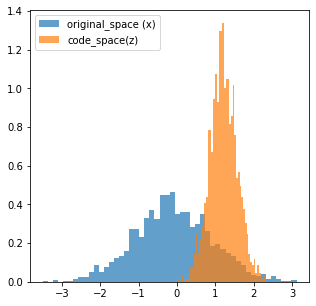

In [442]:
input_tensor = torch.tensor(test_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],

                        labels_list=["original_space (x)","code_space(z)"])

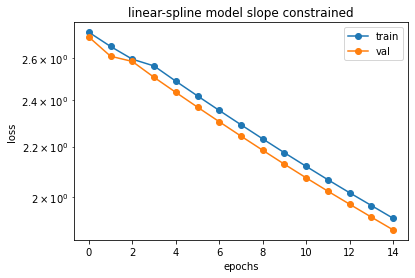

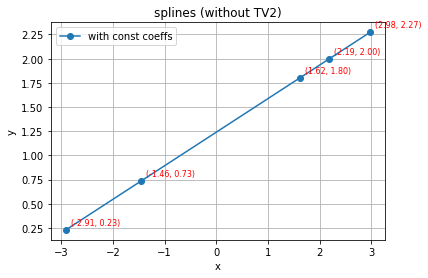

slopes: constrrained coeffs: tensor([[0.3467, 0.3467, 0.3467, 0.3466, 0.3468]], grad_fn=<ClampBackward1>)


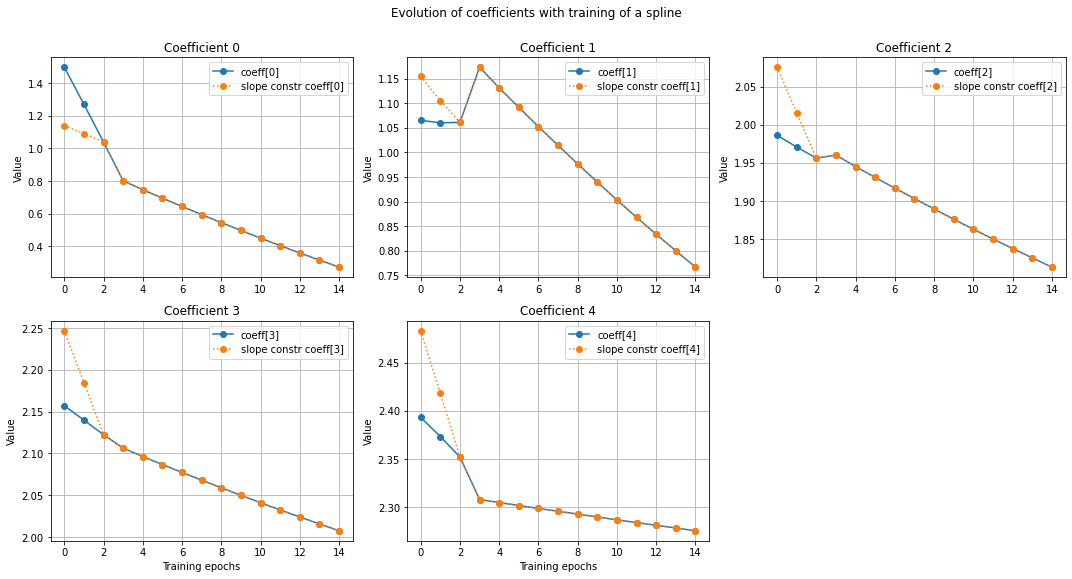

In [443]:
plot_loss_curves(train_loss=train_loss2, val_loss=val_loss2,
                title="linear-spline model slope constrained", log_scale=1)

x2pos,y2pos= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
# plt.figure(figsize=(8,8))
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.legend()
plt.show()
## 
print(f"slopes: constrrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol2), 
                        np.array(coeffs_const_evol2), log_scale=0)

In [444]:
train_loss21, val_loss21, coeffs_unconstrained_evol21, coeffs_const_evol21 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=15, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005, #
    print_after=1,
    track_coefficients=1,
    type_model="scls",
    tv2_regulation=True,
    lambda_tv2=2
) 

Training Progress:   7%|▋         | 1/15 [00:26<06:15, 26.85s/it]

Epoch 1/15,  train NLL+2XTV2: 1.7950410302010171, Training NLL Loss: 1.7937681636140197, Validation NLL Loss: 1.675754126548767, LR: 0.0005


Training Progress:  13%|█▎        | 2/15 [00:51<05:35, 25.80s/it]

Epoch 2/15,  train NLL+2XTV2: 1.6104672450537139, Training NLL Loss: 1.6092781132372813, Validation NLL Loss: 1.5081323852539064, LR: 0.0005


Training Progress:  20%|██        | 3/15 [01:17<05:07, 25.62s/it]

Epoch 3/15,  train NLL+2XTV2: 1.4560924263570487, Training NLL Loss: 1.454889928492707, Validation NLL Loss: 1.3677404950857162, LR: 0.0005


Training Progress:  27%|██▋       | 4/15 [01:43<04:42, 25.66s/it]

Epoch 4/15,  train NLL+2XTV2: 1.329071256602638, Training NLL Loss: 1.32790742698345, Validation NLL Loss: 1.252764575123787, LR: 0.0005


Training Progress:  33%|███▎      | 5/15 [02:11<04:25, 26.58s/it]

Epoch 5/15,  train NLL+2XTV2: 1.2231665623422965, Training NLL Loss: 1.221948386796438, Validation NLL Loss: 1.1561619700193406, LR: 0.0005


Training Progress:  40%|████      | 6/15 [02:38<04:02, 26.92s/it]

Epoch 6/15,  train NLL+2XTV2: 1.1352590369483602, Training NLL Loss: 1.1340554538913128, Validation NLL Loss: 1.0762032825946808, LR: 0.0005


Training Progress:  47%|████▋     | 7/15 [03:01<03:23, 25.45s/it]

Epoch 7/15,  train NLL+2XTV2: 1.0613585530741152, Training NLL Loss: 1.0600970409421095, Validation NLL Loss: 1.009213008761406, LR: 0.0005


Training Progress:  53%|█████▎    | 8/15 [03:25<02:55, 25.06s/it]

Epoch 8/15,  train NLL+2XTV2: 1.0000129800478208, Training NLL Loss: 0.9988170198987668, Validation NLL Loss: 0.9547329425811768, LR: 0.0005


Training Progress:  60%|██████    | 9/15 [03:49<02:29, 24.86s/it]

Epoch 9/15,  train NLL+2XTV2: 0.9496789782498776, Training NLL Loss: 0.9485391789046536, Validation NLL Loss: 0.908453249335289, LR: 0.0005


Training Progress:  67%|██████▋   | 10/15 [04:13<02:02, 24.53s/it]

Epoch 10/15,  train NLL+2XTV2: 0.906641029836586, Training NLL Loss: 0.9054285443636119, Validation NLL Loss: 0.8690290504693985, LR: 0.0005


Training Progress:  73%|███████▎  | 11/15 [04:37<01:36, 24.21s/it]

Epoch 11/15,  train NLL+2XTV2: 0.8697649293867257, Training NLL Loss: 0.8686097119236564, Validation NLL Loss: 0.8363550344705581, LR: 0.0005


Training Progress:  80%|████████  | 12/15 [04:59<01:11, 23.68s/it]

Epoch 12/15,  train NLL+2XTV2: 0.839188279662259, Training NLL Loss: 0.8380170094731942, Validation NLL Loss: 0.8080475360155106, LR: 0.0005


Training Progress:  87%|████████▋ | 13/15 [05:22<00:46, 23.34s/it]

Epoch 13/15,  train NLL+2XTV2: 0.8120450075355062, Training NLL Loss: 0.8109037162354591, Validation NLL Loss: 0.7841522275209427, LR: 0.0005


Training Progress:  93%|█████████▎| 14/15 [05:45<00:23, 23.33s/it]

Epoch 14/15,  train NLL+2XTV2: 0.7901890381545007, Training NLL Loss: 0.7888947354746151, Validation NLL Loss: 0.764464368224144, LR: 0.0005


Training Progress: 100%|██████████| 15/15 [06:09<00:00, 24.63s/it]

Epoch 15/15,  train NLL+2XTV2: 0.7716132789569322, Training NLL Loss: 0.7703813072086504, Validation NLL Loss: 0.74839078271389, LR: 0.0005
Training complete


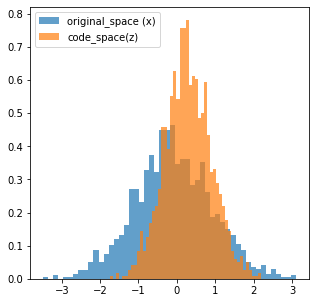

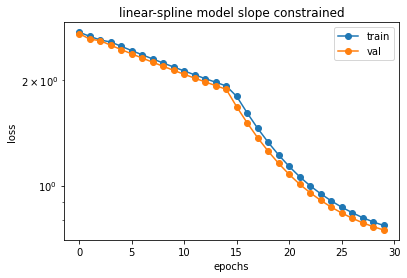

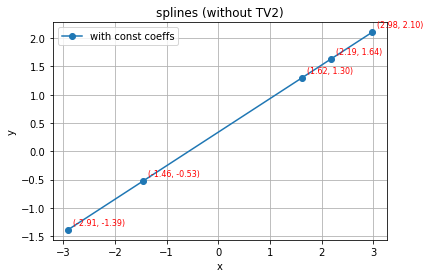

slopes: constrrained coeffs: tensor([[0.5933, 0.5933, 0.5930, 0.5930, 0.5928]], grad_fn=<ClampBackward1>)


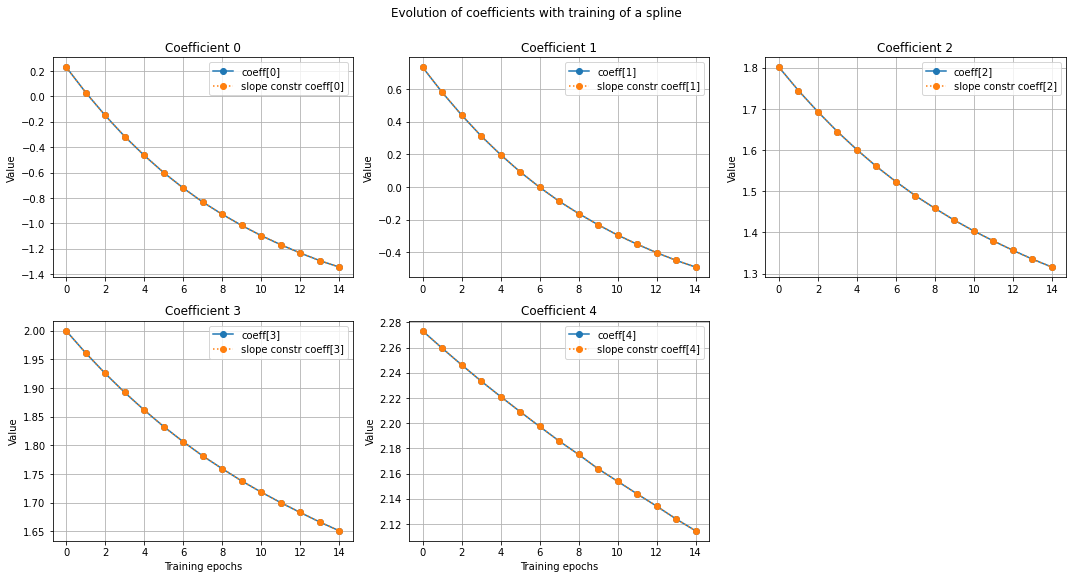

In [445]:
input_tensor = torch.tensor(test_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["original_space (x)","code_space(z)"])

plot_loss_curves(train_loss=train_loss2+train_loss21, val_loss=val_loss2+val_loss21,
                title="linear-spline model slope constrained", log_scale=1)

x2pos,y2pos= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
# plt.figure(figsize=(8,8))
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.legend()
plt.show()
## 
print(f"slopes: constrrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol21), 
                        np.array(coeffs_const_evol21), log_scale=0)

In [446]:
train_loss22, val_loss22, coeffs_unconstrained_evol22, coeffs_const_evol22 = train_and_evaluate(
    model = model2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=15, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.0005, #
    print_after=1,
    track_coefficients=1,
    type_model="scls",
    tv2_regulation=True,
    lambda_tv2=2
) 

Training Progress:   7%|▋         | 1/15 [00:25<06:00, 25.75s/it]

Epoch 1/15,  train NLL+2XTV2: 0.7560859116459874, Training NLL Loss: 0.754804031375952, Validation NLL Loss: 0.7327845113277436, LR: 0.0005


Training Progress:  13%|█▎        | 2/15 [00:49<05:22, 24.83s/it]

Epoch 2/15,  train NLL+2XTV2: 0.7421065440470067, Training NLL Loss: 0.7408806334066922, Validation NLL Loss: 0.7220781663656235, LR: 0.0005


Training Progress:  20%|██        | 3/15 [01:11<04:39, 23.31s/it]

Epoch 3/15,  train NLL+2XTV2: 0.7314912248035732, Training NLL Loss: 0.7303401065260913, Validation NLL Loss: 0.712250748693943, LR: 0.0005


Training Progress:  27%|██▋       | 4/15 [01:35<04:18, 23.53s/it]

Epoch 4/15,  train NLL+2XTV2: 0.7227154010595577, Training NLL Loss: 0.7215110120373908, Validation NLL Loss: 0.7043339312076569, LR: 0.0005


Training Progress:  33%|███▎      | 5/15 [01:59<03:57, 23.71s/it]

Epoch 5/15,  train NLL+2XTV2: 0.7148955892372458, Training NLL Loss: 0.713751832286619, Validation NLL Loss: 0.6975123455524445, LR: 0.0005


Training Progress:  40%|████      | 6/15 [02:21<03:29, 23.24s/it]

Epoch 6/15,  train NLL+2XTV2: 0.7077750574091917, Training NLL Loss: 0.7065730575143321, Validation NLL Loss: 0.6915768585801124, LR: 0.0005


Training Progress:  47%|████▋     | 7/15 [02:44<03:04, 23.05s/it]

Epoch 7/15,  train NLL+2XTV2: 0.7021780178372229, Training NLL Loss: 0.7009775215167722, Validation NLL Loss: 0.6866017317771912, LR: 0.0005


Training Progress:  53%|█████▎    | 8/15 [03:05<02:38, 22.60s/it]

Epoch 8/15,  train NLL+2XTV2: 0.6972290485484435, Training NLL Loss: 0.6960798933425313, Validation NLL Loss: 0.6822464079260826, LR: 0.0005


Training Progress:  60%|██████    | 9/15 [03:32<02:22, 23.74s/it]

Epoch 9/15,  train NLL+2XTV2: 0.6931972280208535, Training NLL Loss: 0.6920671766654181, Validation NLL Loss: 0.6788052502274513, LR: 0.0005


Training Progress:  67%|██████▋   | 10/15 [03:53<01:55, 23.05s/it]

Epoch 10/15,  train NLL+2XTV2: 0.690067335580186, Training NLL Loss: 0.6888967712362709, Validation NLL Loss: 0.6763396837711334, LR: 0.0005


Training Progress:  73%|███████▎  | 11/15 [04:15<01:30, 22.56s/it]

Epoch 11/15,  train NLL+2XTV2: 0.6874052545354217, Training NLL Loss: 0.686176716400296, Validation NLL Loss: 0.6739527670145035, LR: 0.0005


Training Progress:  80%|████████  | 12/15 [04:38<01:08, 22.85s/it]

Epoch 12/15,  train NLL+2XTV2: 0.6855675144106685, Training NLL Loss: 0.6843118056488936, Validation NLL Loss: 0.6725790653824806, LR: 0.0005


Training Progress:  87%|████████▋ | 13/15 [05:01<00:45, 22.94s/it]

Epoch 13/15,  train NLL+2XTV2: 0.6838009949795896, Training NLL Loss: 0.682651421570737, Validation NLL Loss: 0.671684087574482, LR: 0.0005


Training Progress:  93%|█████████▎| 14/15 [05:23<00:22, 22.42s/it]

Epoch 14/15,  train NLL+2XTV2: 0.6824377398130316, Training NLL Loss: 0.6812830328456132, Validation NLL Loss: 0.6705488206744195, LR: 0.0005


Training Progress: 100%|██████████| 15/15 [05:44<00:00, 22.97s/it]

Epoch 15/15,  train NLL+2XTV2: 0.6818717758218346, Training NLL Loss: 0.6807398316103266, Validation NLL Loss: 0.6704583894014359, LR: 0.0005
Training complete


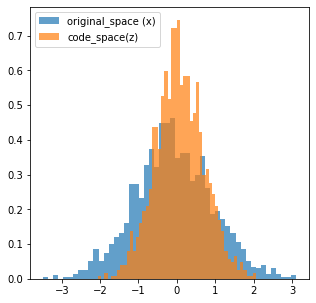

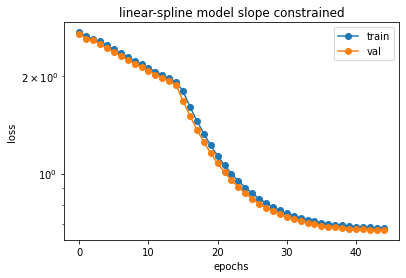

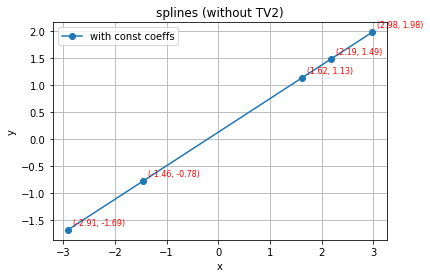

slopes: constrrained coeffs: tensor([[0.6224, 0.6224, 0.6223, 0.6225, 0.6224]], grad_fn=<ClampBackward1>)


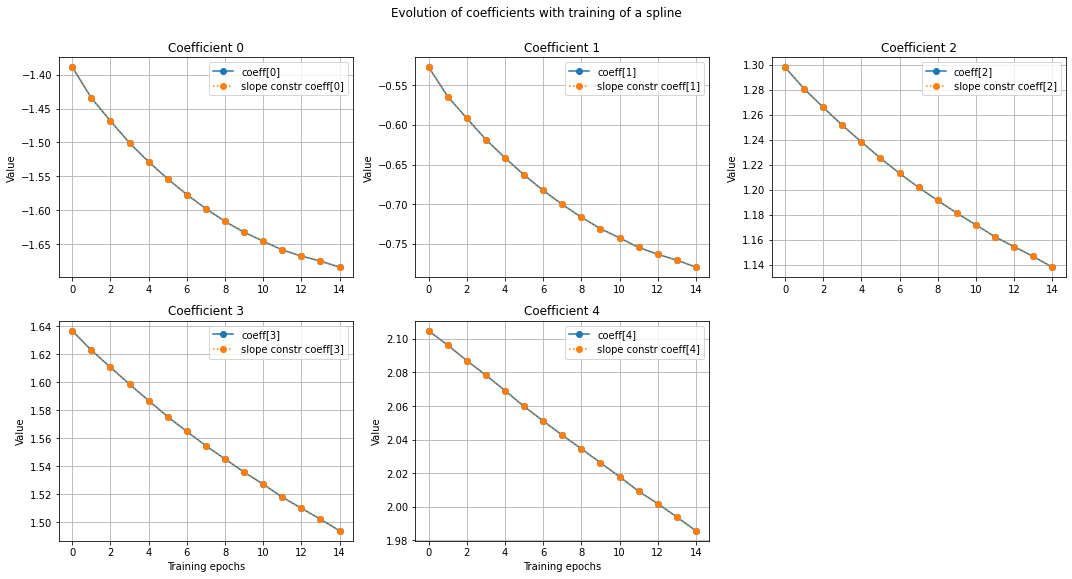

In [449]:
input_tensor = torch.tensor(test_data)
output_tensor2=model2(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor2.detach().numpy()
                        ],
                        labels_list=["original_space (x)","code_space(z)"])

plot_loss_curves(train_loss=train_loss2+train_loss21+train_loss22, val_loss=val_loss2+val_loss21+val_loss22,
                title="linear-spline model slope constrained", log_scale=1)

x2pos,y2pos= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
# plt.figure(figsize=(8,8))
plot_with_annotations(x2pos[0][:], y2pos[:],
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.legend()
plt.show()
## 
print(f"slopes: constrrained coeffs: {model2.slopes_tensor(for_projected_coeffs=1)}")
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol22), 
                        np.array(coeffs_const_evol22), log_scale=0)

# everything below is for the negative nodal values case

UPDATE: after using TV2 regularisation, I dont know how correct these conclusions are?

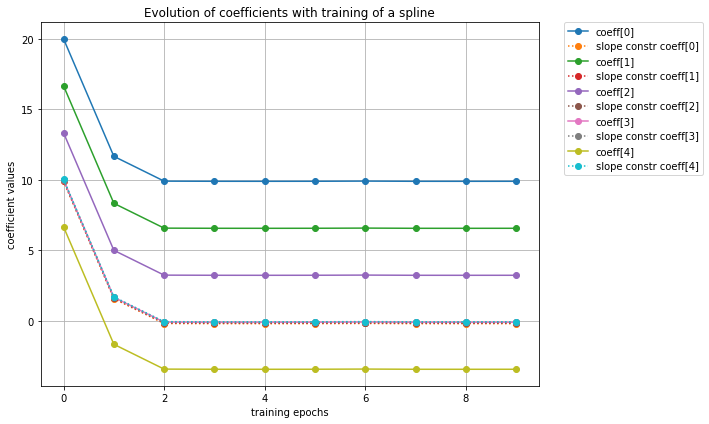

In [117]:
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol2), 
                        np.array(coeffs_const_evol2), log_scale=0)

In [120]:
model2.nodal_val_loc_tensor

tensor([[-20.0000, -16.6667, -13.3333, -10.0000,  -6.6667,  -3.3333,   0.0000]])

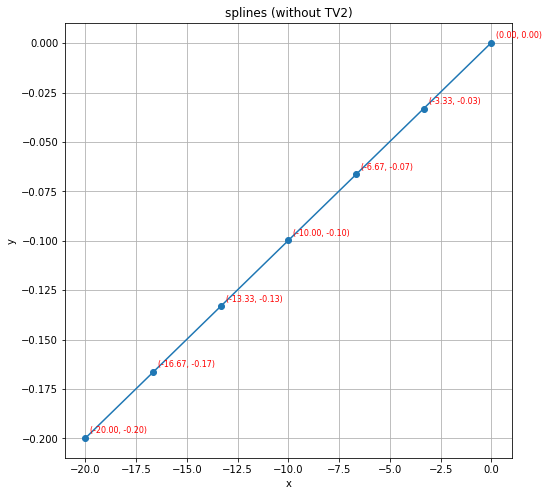

In [121]:
x2,y2= model2.nodal_val_loc_tensor.detach().numpy(),model2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
plt.figure(figsize=(8,8))
plot_with_annotations(x2[0], y2,
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.show()

### Observation
1. for negative nodal points, learned fn values X10^{-2} off from the correct values 
2. For all +ve nodal points:
    2.1 If i keep range to be 6, SIZE=7 and these nodal values:0.1,1.7,2.7,3.4,4.3,5.1,5.8
    then my slope learned was ~2.
    
    2.2 If i keep range to be 6, SIZE=5 and nodal vals: 0.1,1.7,3.4,4.7,5.8
        ITS A BIT COMPLICATED
    
    2.3 Interesting thing I noted:
        -0.1,0.12,0.7,1.6,3.0 (range 10, but whatever, size=5)
        when i changed 0.7->1.4,0.15, the performance worsened.
       
        (THIS IS EXACTLY WHAT THE AUTHORS ALSO MENTIONED IN THEIR WORK THAT 
        FINDING THE APPROPRIATE POSITION OF NODAL VALUES IS A DIFFICULT 
        TASK. IN THEIR WORK, THEY TRIED TO OVERCOME IT USING TV-2 REGULARISATION)